In [2]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.pairs_selection import *
from util.backtest import *
from util.bands import *

import warnings
warnings.filterwarnings(action='ignore')

import pickle
from pathlib import Path

In [3]:
# Data load
pairs_list = [#('CJ', 'CJ4우(전환)'),
 ('CJ', 'CJ우'),
 ('CJ제일제당', 'CJ제일제당 우'),
 ('DB하이텍', 'DB하이텍1우'),
 #('DL이앤씨', 'DL이앤씨2우(전환)'),
 #('DL이앤씨', 'DL이앤씨우'),
 ('GS', 'GS우'),
 ('JW중외제약', 'JW중외제약2우B'),
 ('JW중외제약', 'JW중외제약우'),
 ('LG', 'LG우'),
 ('LG생활건강', 'LG생활건강우'),
 ('LG전자', 'LG전자우'),
 ('LG화학', 'LG화학우'),
# ('LX하우시스', 'LX하우시스우'),
 ('NH투자증권', 'NH투자증권우'),
 #('SK', 'SK우'),
 ('SK네트웍스', 'SK네트웍스우'),
 ('SK이노베이션', 'SK이노베이션우'),
 ('S-Oil', 'S-Oil우'),
 ('금호석유', '금호석유우'),
 ('넥센타이어', '넥센타이어1우B'),
 ('대상', '대상우'),
 ('대한항공', '대한항공우'),
 #('미래에셋증권', '미래에셋증권2우B'),
 ('미래에셋증권', '미래에셋증권우'),
 ('삼성SDI', '삼성SDI우'),
 #('삼성물산', '삼성물산우B'),
 ('삼성전기', '삼성전기우'),
 ('삼성전자', '삼성전자우'),
 ('삼성화재', '삼성화재우'),
 #('아모레G', '아모레G3우(전환)'),
 ('아모레G', '아모레G우'),
 ('아모레퍼시픽', '아모레퍼시픽우'),
 ('유한양행', '유한양행우'),
 #('하이트진로', '하이트진로2우B'),
 ('한국금융지주', '한국금융지주우'),
 #('한화', '한화3우B'),
 ('한화', '한화우'),
 ('한화솔루션', '한화솔루션우'),
 ('현대건설', '현대건설우'),
 ('현대차', '현대차2우B'),
 ('현대차', '현대차3우B'),
 ('현대차', '현대차우'),
 ('호텔신라', '호텔신라우')]

main_path = Path('/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv')
ohlcv_list = []
stock_names = []
for x in main_path.iterdir():
    if x.is_file():
        data = pd.read_csv(x, index_col=0, parse_dates=True)
        ohlcv_list.append(data)
        stock_names.append(x.name.split('_')[0])
ohlcv_dict = dict(zip(stock_names, ohlcv_list))

In [4]:
# Pairs selection
selection = PairsSelection(pairs_list=pairs_list, ohlcv_dict=ohlcv_dict)
selection.get_selected_pairs()
selection.get_selected_pairs_volume()
selection.get_selected_pairs_volatility()
selection.get_selected_pairs_volume_volatility()
selected_pairs_df = selection._selected_pairs_df
selected_volume_pairs_df = selection._selected_volume_pairs_df
selected_volatility_pairs_df = selection._selected_volatility_pairs_df
selected_volume_volatility_pairs_df = selection._selected_volume_volatility_pairs_df

In [5]:
# Save selected pairs dictionary
"""
save_pickle1 = selected_pairs_df['pairs'].to_dict()
save_pickle2 = selected_volume_pairs_df['pairs'].to_dict()
save_pickle3 = selected_volatility_pairs_df['pairs'].to_dict()
save_pickle4 = selected_volume_volatility_pairs_df['pairs'].to_dict()

with open('data/moving_pairs.pickle', 'wb') as fw:
    pickle.dump(save_pickle1, fw)
with open('data/moving_pairs_volume.pickle', 'wb') as fw:
    pickle.dump(save_pickle2, fw)
with open('data/moving_pairs_volatility.pickle', 'wb') as fw:
    pickle.dump(save_pickle3, fw)
with open('data/moving_pairs_volume_volatility.pickle', 'wb') as fw:
    pickle.dump(save_pickle4, fw)
"""

"\nsave_pickle1 = selected_pairs_df['pairs'].to_dict()\nsave_pickle2 = selected_volume_pairs_df['pairs'].to_dict()\nsave_pickle3 = selected_volatility_pairs_df['pairs'].to_dict()\nsave_pickle4 = selected_volume_volatility_pairs_df['pairs'].to_dict()\n\nwith open('data/moving_pairs.pickle', 'wb') as fw:\n    pickle.dump(save_pickle1, fw)\nwith open('data/moving_pairs_volume.pickle', 'wb') as fw:\n    pickle.dump(save_pickle2, fw)\nwith open('data/moving_pairs_volatility.pickle', 'wb') as fw:\n    pickle.dump(save_pickle3, fw)\nwith open('data/moving_pairs_volume_volatility.pickle', 'wb') as fw:\n    pickle.dump(save_pickle4, fw)\n"

In [7]:
moving_pairs = selected_pairs_df['pairs']

trade_dates_all = []
used_pairs_list_all = []

for t in range(len(moving_pairs) - 1):
    start = moving_pairs.index[t]
    end = moving_pairs.index[t + 1]
    print()
    print(f"<<{start}부터 {end}까지 (진입)>>")
    trade_dates_all_pairs = []
    used_pairs_list = []
    for i in range(len(moving_pairs[t])):
        using_pairs = moving_pairs[t][i]
        common = using_pairs[0]
        preferred = using_pairs[1]
        # print()
        print(f"--- 사용페어: {common} & {preferred} ---")
        common_price = ohlcv_dict[common]['종가'].rename(common)  # 수정종가 사용
        preferred_price = ohlcv_dict[preferred]['종가'].rename(preferred)
        pairs_prices = pd.concat([common_price, preferred_price], axis=1)

        # get spread
        first = pairs_prices.dropna().iloc[:, 0]  # 보통주
        second = pairs_prices.dropna().iloc[:, 1]  # 우선주
        spread = get_log_spread(first, second)  # lny-lnx

        # make bands
        window = 20
        mult = 2
        mult2 = 2.5
        df_bb = bollinger_bands_double(spread, window, mult, mult2).dropna()

        sp, lb, ub, ma = df_bb.price, df_bb.lb, df_bb.ub, df_bb.MA
        lb2, ub2 = df_bb.lb2, df_bb.ub2
        trade_dates = get_trade_dates_bb_m(sp, ub, lb, ma)
        #trade_dates = get_trade_dates_bbd_m(sp, ub, lb, ub2, lb2, ma)

        trade_dates = trade_dates[(trade_dates.entry >= start) & (trade_dates.entry < end)].reset_index(drop=True)

        if len(trade_dates) > 0:
            rets = []
            for i in range(len(trade_dates)):
                second_ret = (second[trade_dates.entry[i]:
                                     trade_dates.exit[i]].pct_change()[1:] + 1).cumprod()[-1] - 1
                first_ret = (first[trade_dates.entry[i]:
                                   trade_dates.exit[i]].pct_change()[1:] + 1).cumprod()[-1] - 1
                ret = (second_ret-first_ret)*trade_dates.position.array[i]
                rets.append(ret)
            rets = pd.Series(rets, index=trade_dates.exit)
            trade_dates['ret'] = rets.reset_index(drop=True)
            trade_dates_all_pairs.append(trade_dates)
            used_pairs_list.append(using_pairs)
    trade_dates_all.append(trade_dates_all_pairs)
    used_pairs_list_all.append(used_pairs_list)

for i in range(len(trade_dates_all)):
    for j in range(len(trade_dates_all[i])):
        trade_dates_all[i][j]['asset'] = [used_pairs_list_all[i][j]] * len(trade_dates_all[i][j])
trade_dates_all = [ele for ele in trade_dates_all if ele != []]
list_ = []
for i in range(len(trade_dates_all)):
    d = pd.concat(trade_dates_all[i]).sort_values(['entry', 'exit']).reset_index(drop=True)
    list_.append(d)
all_trades_df = pd.concat(list_).reset_index(drop=True)
all_trades_df = all_trades_df.sort_values(['entry', 'exit'])

cost = 0.008
all_trades_df['ret'] = all_trades_df['ret'] - cost


<<2009-01-02 00:00:00부터 2009-06-25 00:00:00까지 (진입)>>
--- 사용페어: 호텔신라 & 호텔신라우 ---
--- 사용페어: JW중외제약 & JW중외제약2우B ---
--- 사용페어: 한화 & 한화우 ---
--- 사용페어: JW중외제약 & JW중외제약우 ---
--- 사용페어: SK네트웍스 & SK네트웍스우 ---
--- 사용페어: LG화학 & LG화학우 ---
--- 사용페어: 유한양행 & 유한양행우 ---
--- 사용페어: 현대건설 & 현대건설우 ---
--- 사용페어: 한화솔루션 & 한화솔루션우 ---

<<2009-06-25 00:00:00부터 2009-12-11 00:00:00까지 (진입)>>
--- 사용페어: CJ제일제당 & CJ제일제당 우 ---
--- 사용페어: 금호석유 & 금호석유우 ---
--- 사용페어: 한화솔루션 & 한화솔루션우 ---
--- 사용페어: 한화 & 한화우 ---

<<2009-12-11 00:00:00부터 2010-06-09 00:00:00까지 (진입)>>
--- 사용페어: 미래에셋증권 & 미래에셋증권우 ---
--- 사용페어: JW중외제약 & JW중외제약2우B ---
--- 사용페어: 한화 & 한화우 ---
--- 사용페어: 현대차 & 현대차3우B ---
--- 사용페어: 삼성SDI & 삼성SDI우 ---
--- 사용페어: LG & LG우 ---
--- 사용페어: SK네트웍스 & SK네트웍스우 ---
--- 사용페어: 대한항공 & 대한항공우 ---
--- 사용페어: 넥센타이어 & 넥센타이어1우B ---
--- 사용페어: CJ & CJ우 ---
--- 사용페어: NH투자증권 & NH투자증권우 ---
--- 사용페어: 삼성전자 & 삼성전자우 ---
--- 사용페어: S-Oil & S-Oil우 ---
--- 사용페어: LG전자 & LG전자우 ---

<<2010-06-09 00:00:00부터 2010-11-29 00:00:00까지 (진입)>>
--- 사용페어: 호텔신라 & 호텔신라우 ---

In [9]:
# Performances

## all_trades_df.to_csv("data/trades_df.csv")

rets_list_by_asset = []
cumsum_rets_list_by_asset = []
ret_by_asset = all_trades_df.groupby('asset').agg(
    ['mean', 'var','sum', 'count'])['ret'].sort_values(
    'mean', ascending=False)
for i in range(len(ret_by_asset.index)):
    trade_by_asset = all_trades_df[all_trades_df.asset == ret_by_asset.index[i]]
    rets_by_asset = trade_by_asset.set_index('exit').ret.rename(ret_by_asset.index[i])
    cumsum_rets_by_asset = rets_by_asset.cumsum()
    rets_list_by_asset.append(rets_by_asset)
    cumsum_rets_list_by_asset.append(cumsum_rets_by_asset)

In [ ]:
ret_by_asset = all_trades_df.groupby('asset').agg(['mean','var','sum','count'])['ret'].sort_values('mean', ascending=False)
ret_by_asset.mean()[0]

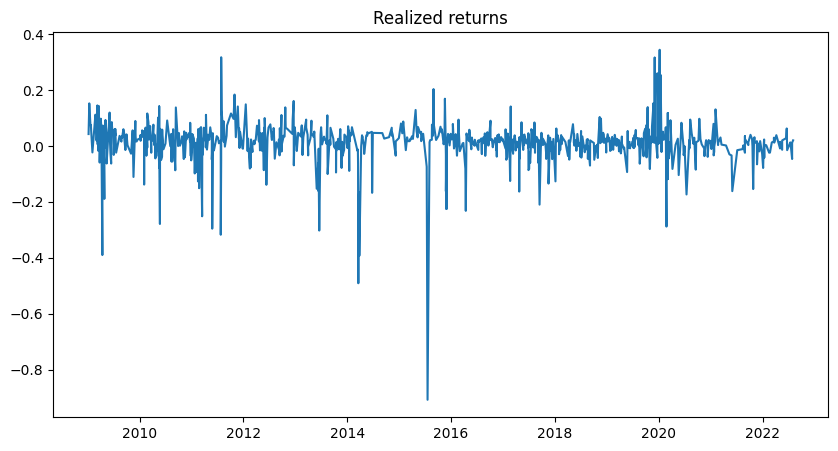

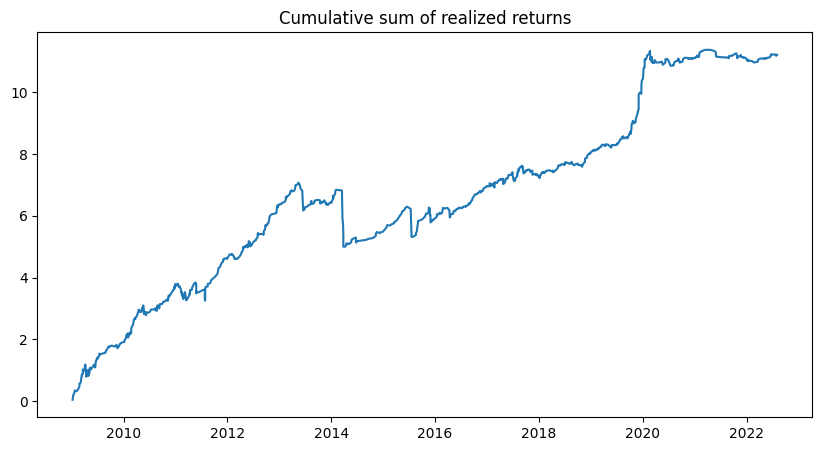

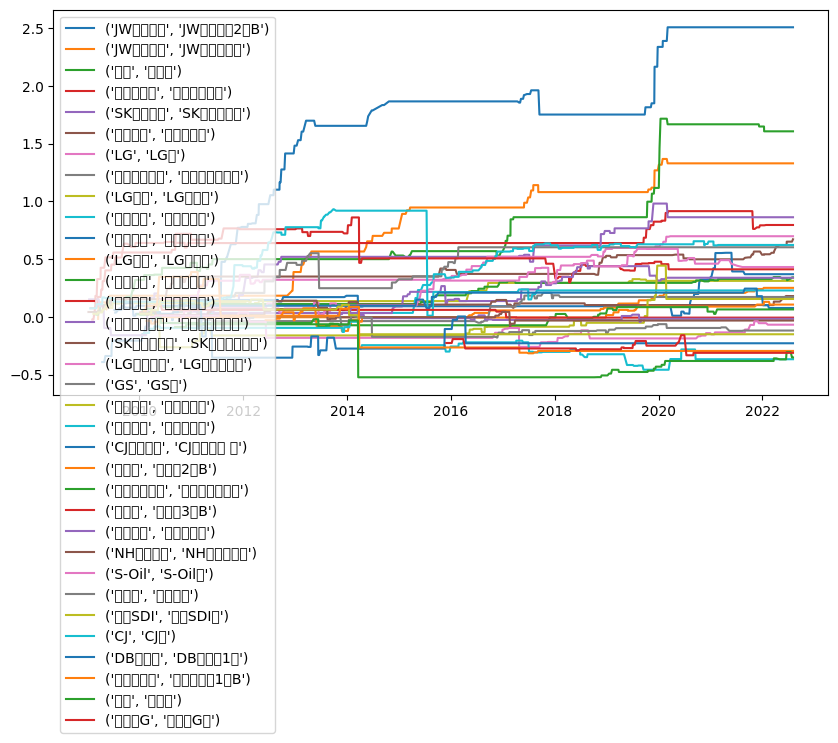

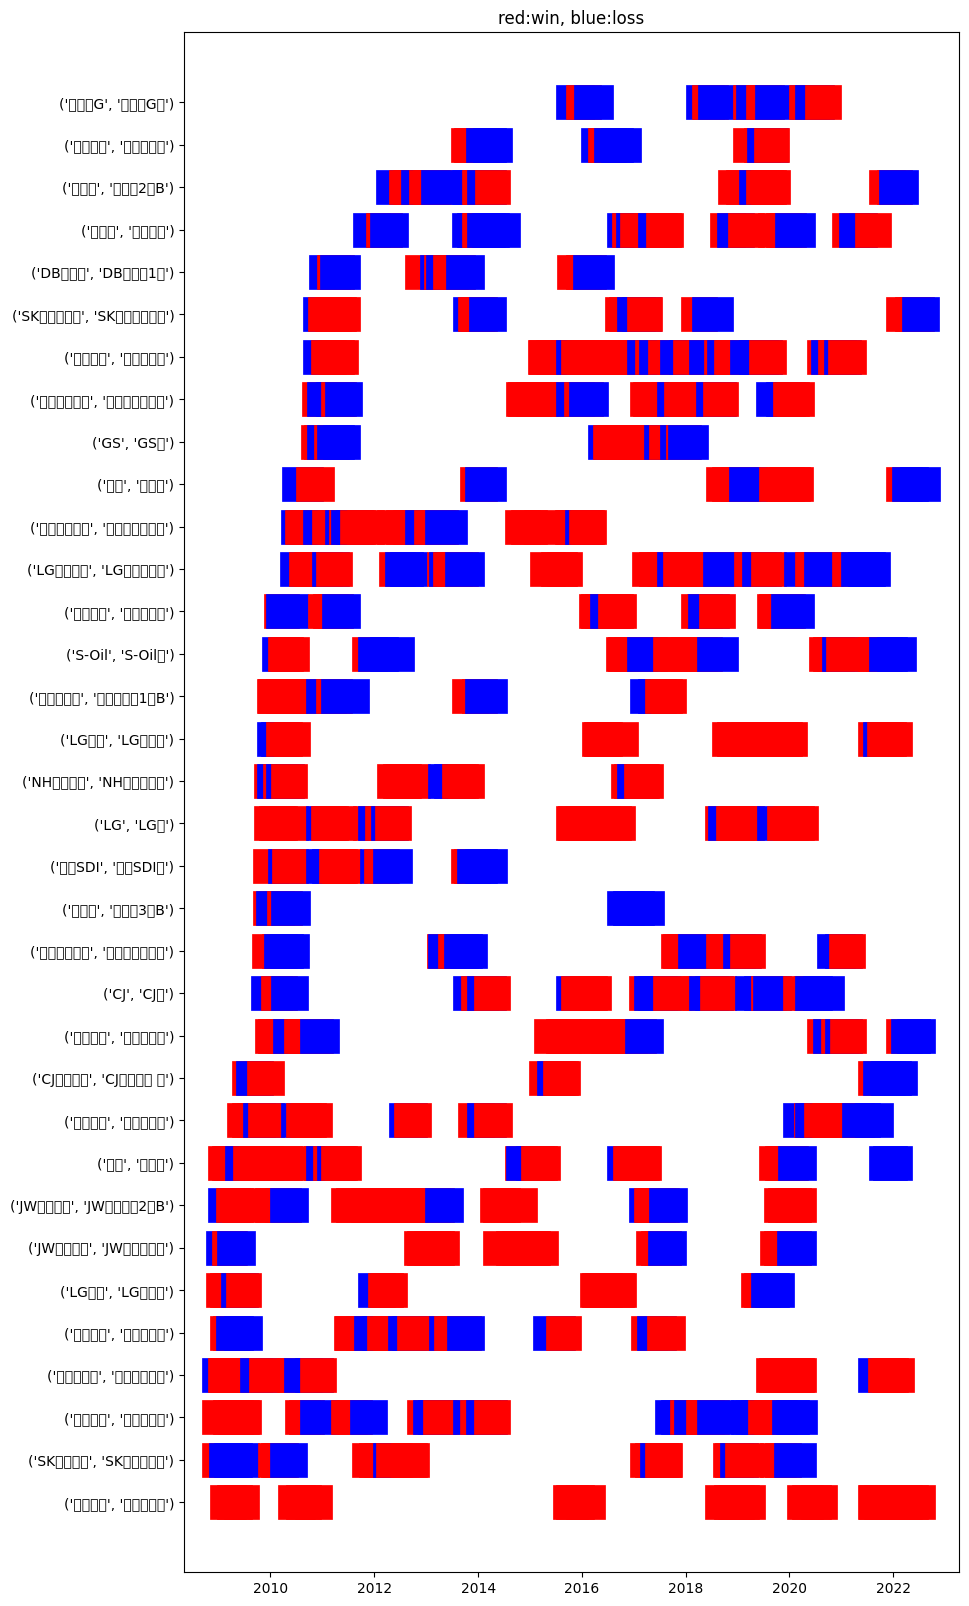

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Realized returns')
plt.plot(all_trades_df.sort_values('exit')['exit'],
         all_trades_df.sort_values('exit')['ret'])

plt.figure(figsize=(10, 5))
plt.title('Cumulative sum of realized returns')
plt.plot(all_trades_df.sort_values('exit')['exit'],
         all_trades_df.sort_values('exit')['ret'].cumsum())

plt.figure(figsize=(10, 5))
plt.plot(pd.concat(cumsum_rets_list_by_asset, axis=1).fillna(method='ffill'))
plt.legend(pd.concat(cumsum_rets_list_by_asset, axis=1).fillna(method='ffill'), loc='best')
plt.show()

the_pairs = all_trades_df['asset'].unique()
all_lines = []
for i in range(len(the_pairs)):
    trades_by_asset = all_trades_df[all_trades_df.asset == the_pairs[i]]

    lines = []
    for t in trades_by_asset.index:
        a_line = pd.DataFrame([i * np.sign(trades_by_asset.ret)[t]] * 2,
                              index=[trades_by_asset.entry[t], trades_by_asset.exit[t]],
                              columns=[f'{the_pairs[i]}'])
        lines.append(a_line)
    all_lines.append(lines)

plt.figure(figsize=(10, 20))
plt.title('red:win, blue:loss')
for j in range(len(all_lines)):
    for i in all_lines[j]:
        if i.iloc[0, 0] < 0:
            plt.plot(i * (-1), c='blue', linewidth=25)
        else:
            plt.plot(i, c='red', linewidth=25)
plt.yticks(ticks=range(len(all_lines)), labels=the_pairs)
plt.savefig('img/tmpimg.png')
plt.show()